Wine データの標準化まで実施

In [36]:
from pm3.wine import Wine

wine = Wine()

X_train_std, y_train = wine.train_std_datasets()
X_test_std, y_test = wine.test_std_datasets()

変動行列を計算

In [37]:
import numpy as np

np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



クラス内変動行列を計算

In [38]:
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row2, mv2 = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row2 - mv2).dot((row2 - mv2).T)
    S_W += class_scatter

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

print('Class label distribution: %s' % np.bincount(y_train)[1:])

Within-class scatter matrix: 13x13
Class label distribution: [41 50 33]


クラスラベルが一様ではないので、スケーリングする

In [39]:
d = 13
S_W = np.zeros((d, d))
for label in range(1, 4):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

print('Scaled Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Scaled Within-class scatter matrix: 13x13


クラス間変動行列の計算

In [40]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    col_vec = mean_vec.reshape(d, 1)
    col_overall = mean_overall.reshape(d, 1)
    S_B += n * (col_vec - col_overall).dot((col_vec - col_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


固有対を計算

In [41]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

for eigen_val in eigen_pairs:
    print(eigen_val[0])

349.61780890599397
172.76152218979385
3.2209587419662555e-14
3.2209587419662555e-14
2.6106523402387364e-14
1.7038977764581827e-14
1.7038977764581827e-14
1.687554433463065e-14
1.687554433463065e-14
7.584950171788759e-15
2.9412105155181146e-15
2.9412105155181146e-15
0.0


判別性をプロット

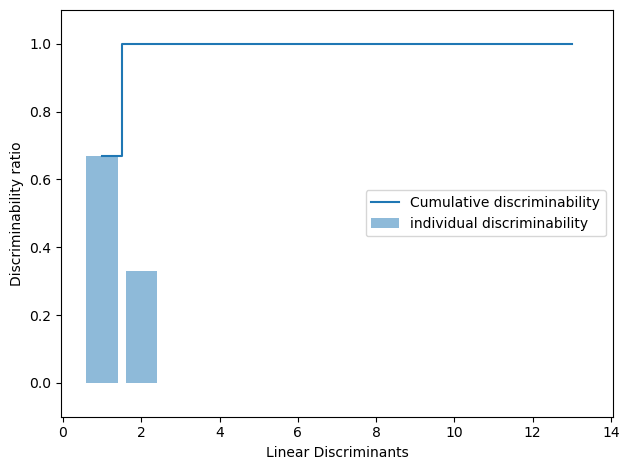

In [42]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

import matplotlib.pyplot as plt

plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual discriminability')
plt.step(range(1, 14), cum_discr, where='mid', label='Cumulative discriminability')
plt.ylabel('Discriminability ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

変換行列を作成

In [43]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real))

print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


データ点を射影

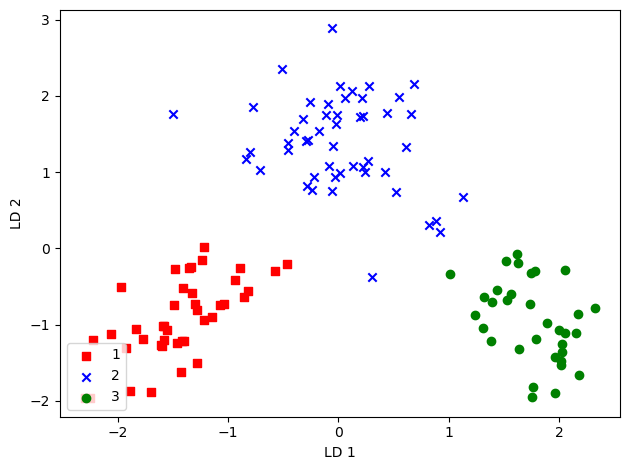

In [44]:
X_train_lda = X_train_std.dot(w)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0], X_train_lda[y_train == l, 1], c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

scikit-learn で実装

/Users/ak-yamamoto/git/k-bokka/py_ml_3rd/packages/pm3/plot.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[y == cl, 0], X[y == cl, 1], facecolor=colors[idx], edgecolor='black',


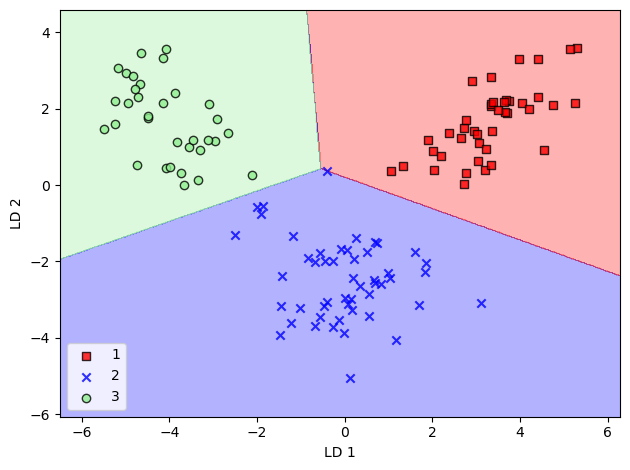

In [45]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from pm3.plot import plot_decision_regions

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

テストデータに対して実行

/Users/ak-yamamoto/git/k-bokka/py_ml_3rd/packages/pm3/plot.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[y == cl, 0], X[y == cl, 1], facecolor=colors[idx], edgecolor='black',


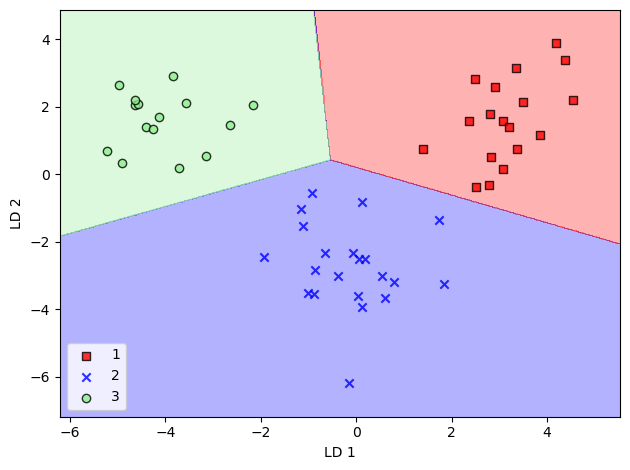

In [46]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()